In [ ]:
import os

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
store_sales=pd.read_csv("train.csv")
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


check for null values in the data set

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116006 entries, 0 to 116005
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    116006 non-null  object
 1   store   116006 non-null  int64 
 2   item    116006 non-null  int64 
 3   sales   116006 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.5+ MB


Dropping store and item columns

In [ ]:
store_sales=store_sales.drop(['store','item'], axis=1)

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116006 entries, 0 to 116005
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    116006 non-null  object
 1   sales   116006 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


converting daye from object datatype to dateTime data type

In [ ]:
store_sales['date']=pd.to_datetime(store_sales['date'])

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116006 entries, 0 to 116005
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    116006 non-null  datetime64[ns]
 1   sales   116006 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 MB


converting date to month period, and then sum the no. of items in each month

In [ ]:
store_sales['date']=store_sales['date'].dt.to_period("M")
monthly_sales=store_sales.groupby("date").sum().reset_index()

converting the resulting sate to timestamp datatype

In [ ]:
monthly_sales['date']=monthly_sales['date'].dt.to_timestamp()

In [ ]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,41853
1,2013-02-01,42806
2,2013-03-01,57136
3,2013-04-01,62912
4,2013-05-01,70621
5,2013-06-01,73932
6,2013-07-01,79070
7,2013-08-01,71204
8,2013-09-01,63559
9,2013-10-01,60969


Visualization

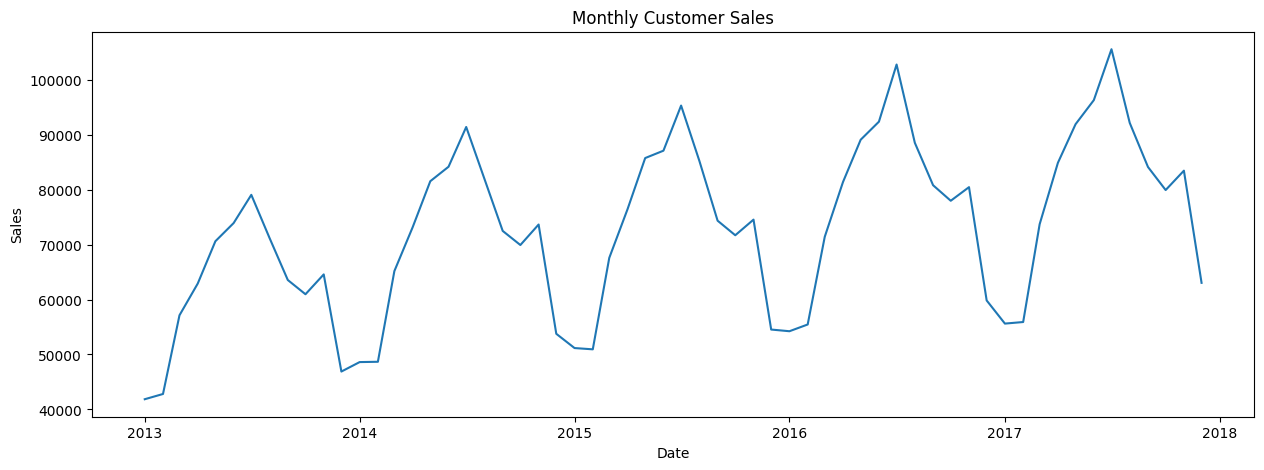

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

call the difference on the sales columns to make the sales data stationary

In [ ]:
monthly_sales['sales_diff']=monthly_sales['sales'].diff()
monthly_sales=monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,42806,953.0
2,2013-03-01,57136,14330.0
3,2013-04-01,62912,5776.0
4,2013-05-01,70621,7709.0
5,2013-06-01,73932,3311.0
6,2013-07-01,79070,5138.0
7,2013-08-01,71204,-7866.0
8,2013-09-01,63559,-7645.0
9,2013-10-01,60969,-2590.0
10,2013-11-01,64581,3612.0


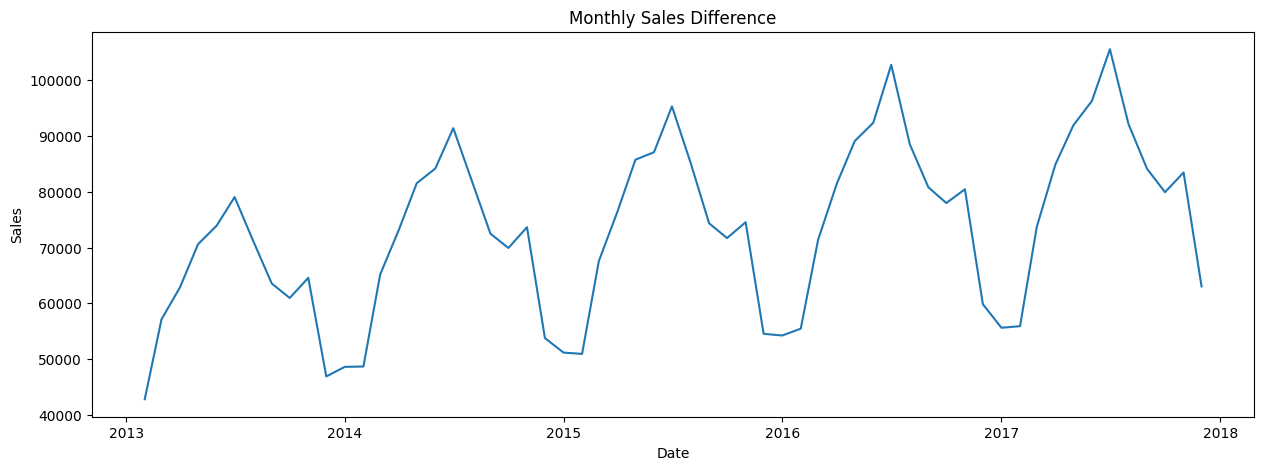

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Sales Difference")
plt.show()

Dropping off sales and date

In [ ]:
supervised_data=monthly_sales.drop(['date','sales'],axis=1)

preparing the supervised data

In [ ]:
for i in range(1,13):
  col_name='month_'+str(i)
  supervised_data[col_name]=supervised_data['sales_diff'].shift(i)
supervised_data=supervised_data.dropna() .reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0,-7866.0,5138.0,3311.0,7709.0,5776.0,14330.0,953.0
1,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0,-7866.0,5138.0,3311.0,7709.0,5776.0,14330.0
2,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0,-7866.0,5138.0,3311.0,7709.0,5776.0
3,8393.0,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0,-7866.0,5138.0,3311.0,7709.0
4,2637.0,8393.0,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0,-7866.0,5138.0,3311.0
5,7239.0,2637.0,8393.0,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0,-7866.0,5138.0
6,-9459.0,7239.0,2637.0,8393.0,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0,-7866.0
7,-9468.0,-9459.0,7239.0,2637.0,8393.0,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0,-7645.0
8,-2567.0,-9468.0,-9459.0,7239.0,2637.0,8393.0,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0,-2590.0
9,3734.0,-2567.0,-9468.0,-9459.0,7239.0,2637.0,8393.0,7971.0,16514.0,57.0,1722.0,-17688.0,3612.0


split the data into Train and Test

In [ ]:
train_data=supervised_data[:-12]
test_data=supervised_data[-12:]
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

Train Data Shape: (35, 13)
Test Data Shape: (12, 13)


In [ ]:
scaler=MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)

In [ ]:
x_train, y_train= train_data[:,1:], train_data[:,0:1]
x_test, y_test= test_data[:,1:], test_data[:,0:1]
y_train=y_train.ravel()
y_test=y_test.ravel()
print("X_train Shape: ", x_train.shape)
print("Y_train Shape: ", y_train.shape)
print("X_test Shape: ", x_test.shape)
print("Y_test Shape: ", y_test.shape)

X_train Shape:  (35, 12)
Y_train Shape:  (35,)
X_test Shape:  (12, 12)
Y_test Shape:  (12,)


Make a prediction data frame to merge the predicted sales prices of all trained algo

In [ ]:
sales_dates=monthly_sales['date'][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)

In [ ]:
act_sales=monthly_sales['sales'][-13:].to_list()
print(act_sales)

[59839, 55624, 55910, 73727, 84902, 91933, 96313, 105585, 92172, 84141, 79941, 83472, 63044]


To create the linear regression model, and predicted output

In [ ]:
lr_model=LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre=lr_model.predict(x_test)

In [ ]:
lr_pre=lr_pre.reshape(-1,1)
#This is a set matrix - contains the input features of the test data , and also the predicted output
lr_pre_test_set=np.concatenate([lr_pre,x_test],axis=1)
lr_pre_test_set=scaler.inverse_transform(lr_pre_test_set)

In [ ]:
result_list=[]
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0]+act_sales[index])
lr_pre_series=pd.Series(result_list, name="Linear Prediction")
predict_df=predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [ ]:
lr_mse=np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae=mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2=r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)

Linear Regression MSE:  1557.3766410406454
Linear Regression MAE:  1213.516858583377
Linear Regression R2:  0.9893135205584865


Visualization of the prediction against actual sales

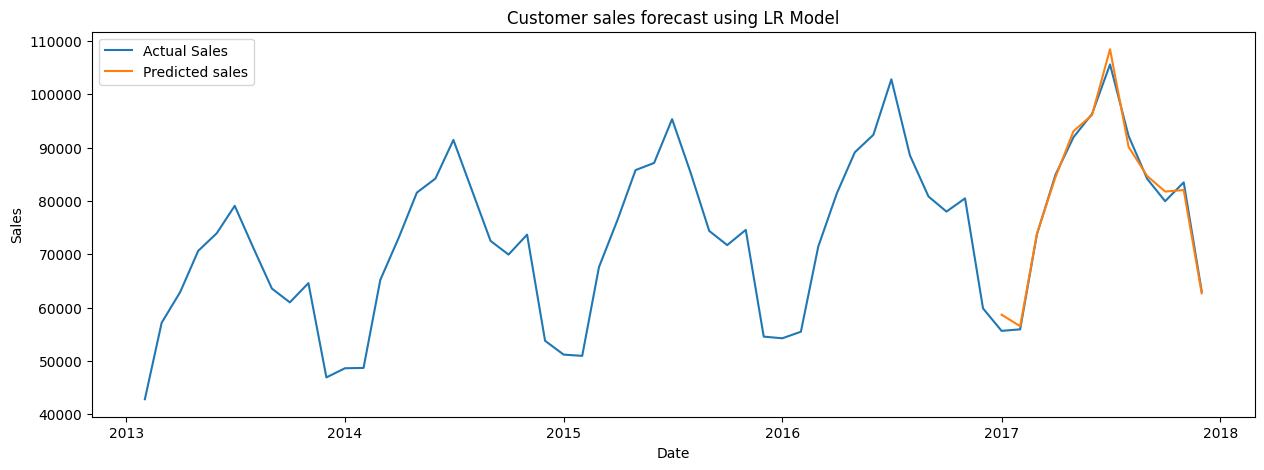

In [ ]:
plt.figure(figsize=(15,5))
#Actual sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
#Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer sales forecast using LR Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted sales'])
plt.show()